In [1]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [2]:
h = 120
w = 160

## Collect DATA

In [3]:
df = pd.read_csv('driver_imgs_list.csv')

In [4]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
paths = []
for n in range(df.shape[0]):
    label = df.iloc[n]['classname']
    name = df.iloc[n]['img']
    path = os.path.join('imgs','train',label, name)
    paths.append(path)
df['path'] = paths

In [6]:
df.head()

,subject,classname,img,path
0,p002,c0,img_44733.jpg,imgs\train\c0\img_44733.jpg
1,p002,c0,img_72999.jpg,imgs\train\c0\img_72999.jpg
2,p002,c0,img_25094.jpg,imgs\train\c0\img_25094.jpg
3,p002,c0,img_69092.jpg,imgs\train\c0\img_69092.jpg
4,p002,c0,img_92629.jpg,imgs\train\c0\img_92629.jpg


In [7]:
labels_df = pd.get_dummies(df['classname'])
df = df.join(labels_df)
df = df.drop('classname', axis=1)
df.head()

,subject,img,path,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,p002,img_44733.jpg,imgs\train\c0\img_44733.jpg,1,0,0,0,0,0,0,0,0,0
1,p002,img_72999.jpg,imgs\train\c0\img_72999.jpg,1,0,0,0,0,0,0,0,0,0
2,p002,img_25094.jpg,imgs\train\c0\img_25094.jpg,1,0,0,0,0,0,0,0,0,0
3,p002,img_69092.jpg,imgs\train\c0\img_69092.jpg,1,0,0,0,0,0,0,0,0,0
4,p002,img_92629.jpg,imgs\train\c0\img_92629.jpg,1,0,0,0,0,0,0,0,0,0


In [8]:
df.tail()

,subject,img,path,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
22419,p081,img_56936.jpg,imgs\train\c9\img_56936.jpg,0,0,0,0,0,0,0,0,0,1
22420,p081,img_46218.jpg,imgs\train\c9\img_46218.jpg,0,0,0,0,0,0,0,0,0,1
22421,p081,img_25946.jpg,imgs\train\c9\img_25946.jpg,0,0,0,0,0,0,0,0,0,1
22422,p081,img_67850.jpg,imgs\train\c9\img_67850.jpg,0,0,0,0,0,0,0,0,0,1
22423,p081,img_9684.jpg,imgs\train\c9\img_9684.jpg,0,0,0,0,0,0,0,0,0,1


In [9]:
df.shape

(22424, 13)

In [10]:
train_df, val_df = train_test_split(df, test_size=0.1)

In [11]:
train_df.shape, val_df.shape

((20181, 13), (2243, 13))

In [12]:
label_names = {'c0': 'safe driving',
                'c1': 'texting - right',
                'c2': 'talking on the phone - right',
                'c3': 'texting - left',
                'c4': 'talking on the phone - left',
                'c5': 'operating the radio',
                'c6': 'drinking',
                'c7': 'reaching behind',
                'c8': 'hair and makeup',
                'c9': 'talking to passenger'}

## Preprocess

In [15]:
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (h,w))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

In [37]:
labels_col = ['c0', 'c1', 'c2', 'c3', 'c4','c5', 'c6','c7', 'c8', 'c9']
def create_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((df['path'].values, df[labels_col].values))
    ds = ds.map(preprocess)
    return ds

In [17]:
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)

tf.Tensor([0 0 1 0 0 0 0 0 0 0], shape=(10,), dtype=uint8)


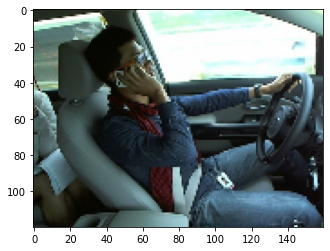

In [77]:
for img, label in train_ds.take(1):
    plt.imshow(img)
    print(label)

## CNN structure

In [20]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

In [21]:
backbone = keras.applications.MobileNetV2(input_shape=[h,w,3], include_top=False)
backbone.trainable = False

In [22]:
backbone.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 60, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 60, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 60, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [23]:
input_layer = backbone.input
backbone_output = backbone.get_layer('block_2_add').output
c1 = Conv2D(64,(3,3),strides=(2,2), padding='same', activation='relu', name='C1')(backbone_output)
c2 = Conv2D(32,(3,3),strides=(2,2), padding='same', activation='relu', name='C2')(c1)
f = Flatten()(c2)
d1 = Dense(256, activation='relu')(f)
d2 = Dense(64, activation='relu')(d1)
d3 = Dense(10, activation='softmax')(d2)



model = Model(inputs=input_layer, outputs=d3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 60, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 60, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 60, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## Train Model

In [24]:
BATCH_SIZE = 64
EPOCHS = 5

In [25]:
train_dataset = train_ds.batch(BATCH_SIZE)
val_dataset = val_ds.batch(BATCH_SIZE)

In [26]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_dataset)

Epoch 1/5
316/316 [==============================] - 17s 48ms/step - loss: 0.4384 - accuracy: 0.8657 - val_loss: 0.0408 - val_accuracy: 0.9866
Epoch 2/5
316/316 [==============================] - 15s 46ms/step - loss: 0.0253 - accuracy: 0.9930 - val_loss: 0.0518 - val_accuracy: 0.9844
Epoch 3/5
316/316 [==============================] - 15s 47ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0916 - val_accuracy: 0.9728
Epoch 4/5
316/316 [==============================] - 15s 47ms/step - loss: 0.0261 - accuracy: 0.9925 - val_loss: 0.0349 - val_accuracy: 0.9897
Epoch 5/5
316/316 [==============================] - 15s 47ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.0329 - val_accuracy: 0.9911


In [61]:
model.save('disatractive_model_detection')

INFO:tensorflow:Assets written to: disatractive_model_detection\assets


C:\Users\WorkStation\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Test Model

### Validation Data

In [28]:
label_names = {'c0': 'safe driving',
                'c1': 'texting - right',
                'c2': 'talking on the phone - right',
                'c3': 'texting - left',
                'c4': 'talking on the phone - left',
                'c5': 'operating the radio',
                'c6': 'drinking',
                'c7': 'reaching behind',
                'c8': 'hair and makeup',
                'c9': 'talking to passenger'}
keys = list(label_names.keys())

def show_pediction(img, pred, label):
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    real_label = label_names[keys[np.argmax(label)]]
    pred_label = label_names[keys[np.argmax(pred)]]
    plt.title(f'Real label: {real_label},\n Predicted label: {pred_label}')
    

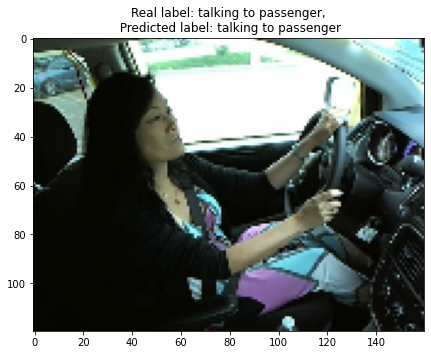

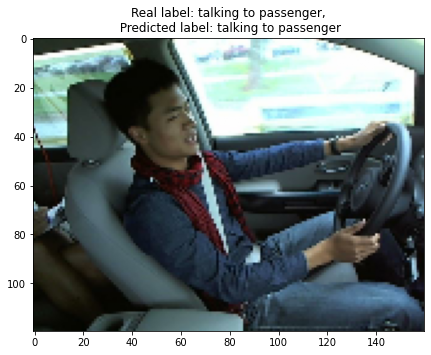

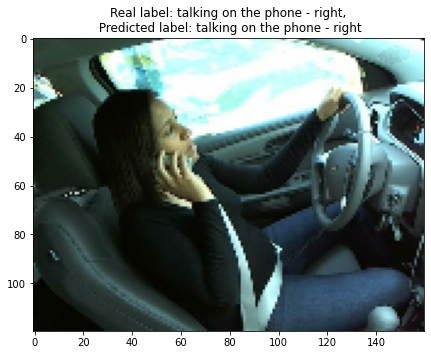

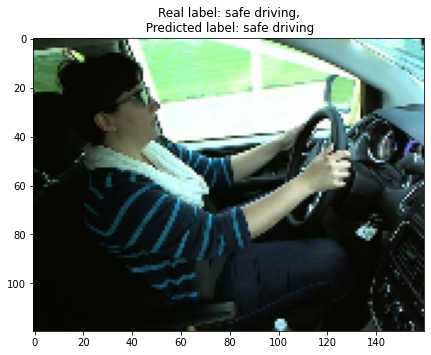

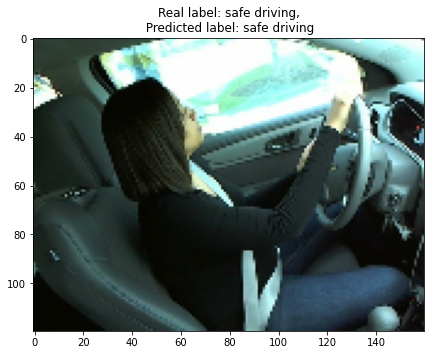

In [76]:
for img, label in val_ds.take(5):
    pred = model.predict(np.array([img]))
    show_pediction(img, pred[0], label)

### Test Data

In [54]:
def preproces_test_img(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (w,h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

def test_model_pred(img, model):
    pred = model.predict(np.array([img]))[0]
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    pred_label = label_names[keys[np.argmax(pred)]]
    plt.title(f'Predicted label: {pred_label}')

In [60]:
test_paths = [os.path.join('imgs/', 'test/', name) for name in os.listdir('imgs/test/')]

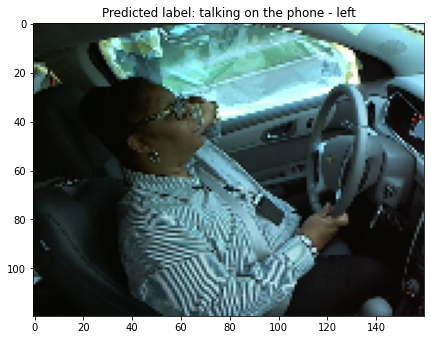

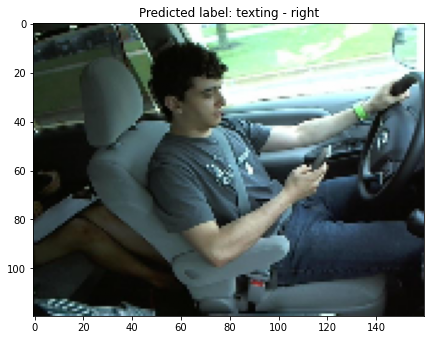

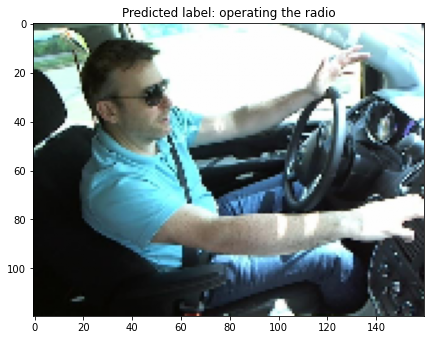

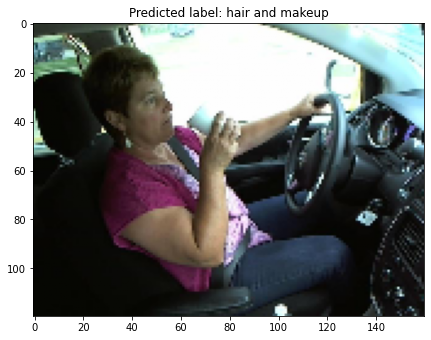

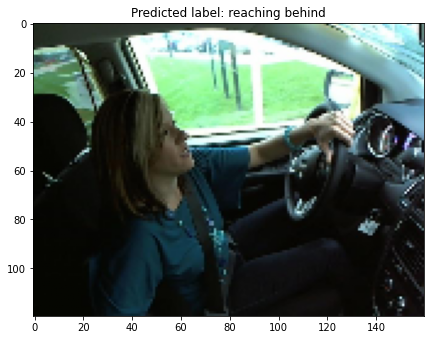

In [75]:
for n in np.random.choice(len(test_paths), 5):
    img = preproces_test_img(test_paths[n])
    test_model_pred(img, model)